In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 16}
matplotlib.rc('font', **font)

import concurrent.futures as cf

from scipy import integrate

import tanh_sinh

import time

In [2]:
tanh_sinh.integrate(
    lambda x: 1/np.sqrt(1-x),
    -1, 1, 1.0e-4, max_steps=10)

(2.828295859397967, 9.791710998860249e-05)

In [3]:
# Smaller eps increases accuracy but requires larger max_steps 
tanh_sinh.integrate(
    lambda x: 1/np.sqrt(1-x),
    -1, 1, 1.0e-7, max_steps=20)

(2.828426852567815, 9.11954817321746e-08)

In [4]:
#Exact
2 *np.sqrt(2)

2.8284271247461903

# Testing double integrals

In [5]:
def gg(x,y):
    return 2*x+3*y

zo = 9.85e-08
xo = 1.92e-07
dz = 1e-8
dx = 1e-8
gg(zo,xo)*dz*dx

7.729999999999999e-23

In [6]:
# Not sure why "dblquad" is inaccurate....
integrate.dblquad(gg, zo-dz/2, zo+dz/2, xo-dx/2 , xo+dx/2)

(6.795000000000014e-23, 7.709775678381578e-29)

In [8]:
# nquad gives correct result
integrate.nquad(gg,[[zo-dz/2, zo+dz/2],[xo-dx/2 , xo+dx/2]])

(7.730000000000017e-23, 8.747834206406101e-29)

# Integration attempts

In [9]:
from csr2d.core2 import psi_s, psi_x, psi_x0, psi_x_exact

# from csr2d.core2 import alpha, alpha_exact_case_B_brentq, alpha_exact

gamma = 5000

## Additional parameters
beta = (1-1/gamma**2)**(1/2)

In [10]:
dz = 1e-8
dx = 1e-8
nz = 103
nx = 105

rho = 5

dx = dx/rho
dz = dz/(2*abs(rho))
    
# Double-sized array for convolution with the density
zvec2 = np.arange(-nz+1,nz+1,1)*dz # center = 0 is at [nz-1]
xvec2 = np.arange(-nx+1,nx+1,1)*dx # center = 0 is at [nx-1]
    
zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
psi_s_grid = psi_s(zm2, xm2, beta) # Numba routines!
psi_x_grid = psi_x0(zm2, xm2, beta, dx) # Numba routines!

# For psi_x grid we can also choose to exclude the points along x=0
xvec2_no_x0 = np.append(xvec2[0:nx-1],xvec2[nx:2*nx])

zm2_no_x0, xm2_no_x0 = np.meshgrid(zvec2, xvec2_no_x0, indexing="ij")
psi_x_grid_no_x0 = psi_x_exact(zm2_no_x0, xm2_no_x0, beta)

#haha = psi_x(zm2_no_x0, xm2_no_x0, beta)

In [11]:
# where the zeroes are
zm2[nz-1,:];
xm2[:,nx-1];

Text(0.5, 0.92, '$\\psi_s(z,x)$')

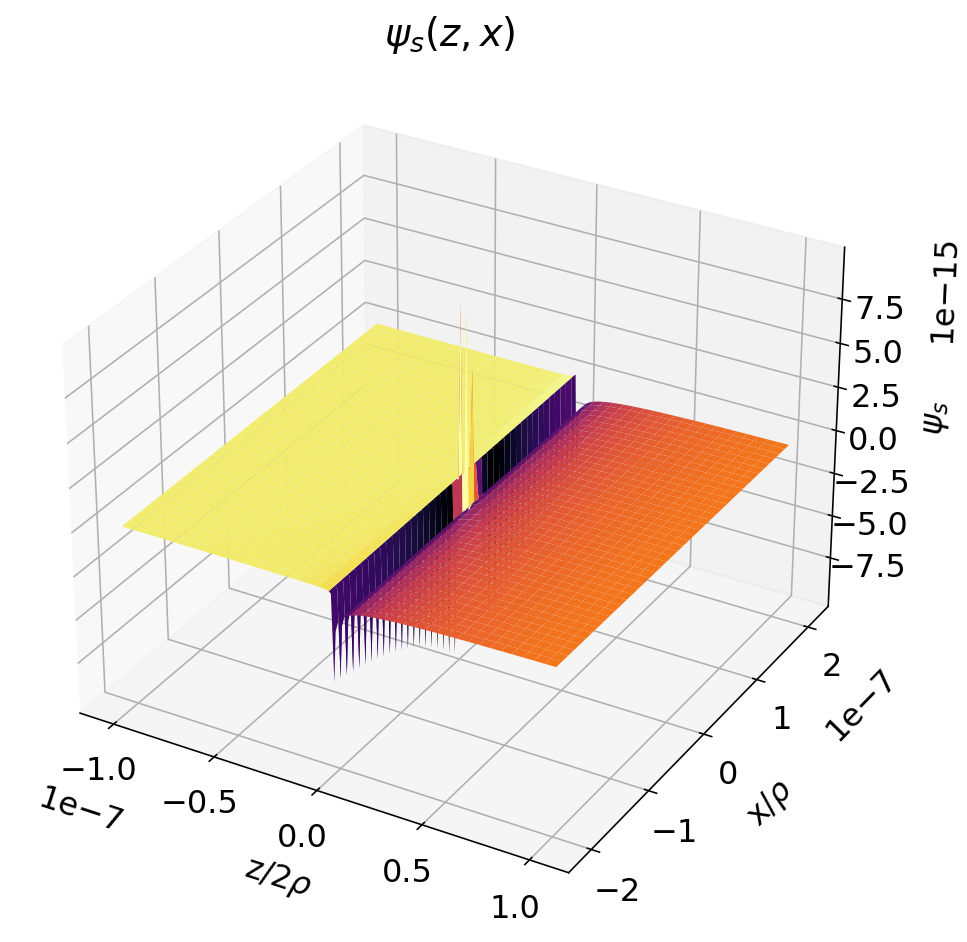

In [42]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(zm2,xm2, psi_s_grid *dx*dz, cmap='inferno')
ax.set_xlabel(r'z/2$\rho$',labelpad=10)
ax.set_ylabel(r'x/$\rho$',labelpad=10)
ax.set_zlabel(r'$\psi_s$',labelpad=10)
ax.set_title(r'$\psi_s(z,x)$')

Text(0.5, 0.92, '$\\psi_x(z,x)$')

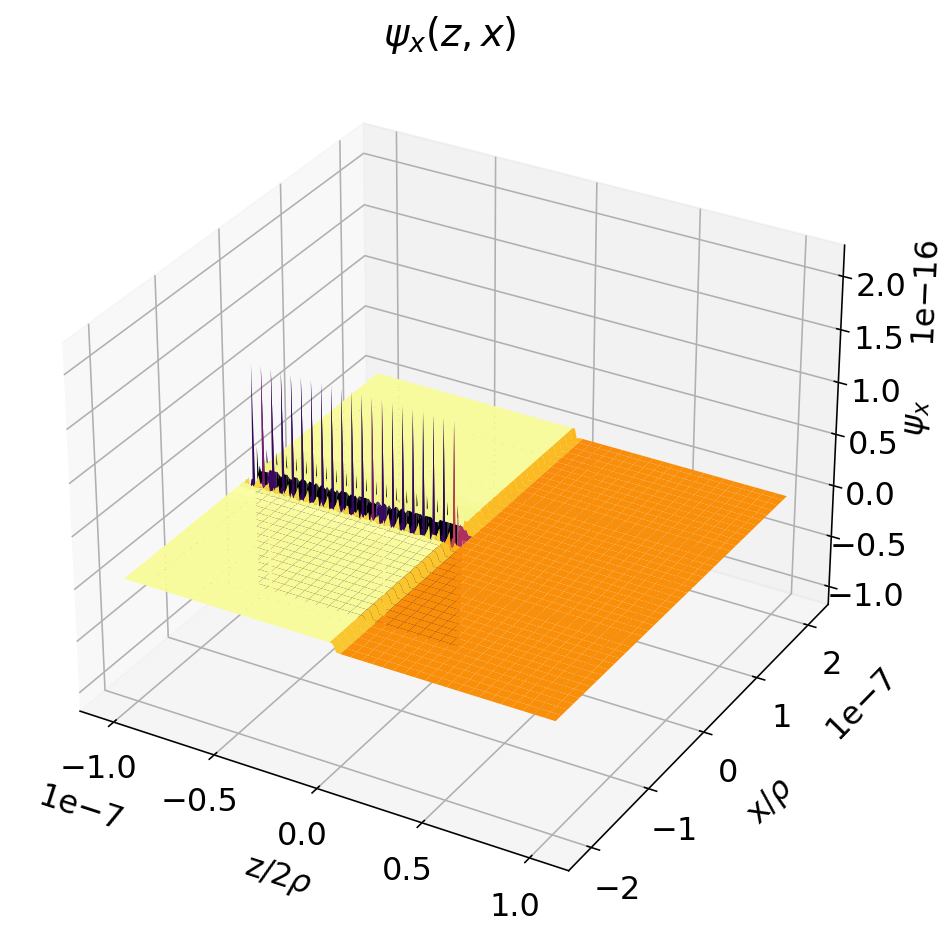

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

labelpad = 10

ax.plot_surface(zm2 ,xm2 , psi_x_grid *dx*dz, cmap='inferno')
ax.set_xlabel(r'z/2$\rho$',labelpad=labelpad)
ax.set_ylabel(r'x/$\rho$',labelpad=labelpad)
ax.set_zlabel(r'$\psi_x$')
ax.set_title(r'$\psi_x(z,x)$',pad=0)

Text(0.5, 0.92, '$\\psi_x(z,x)$')

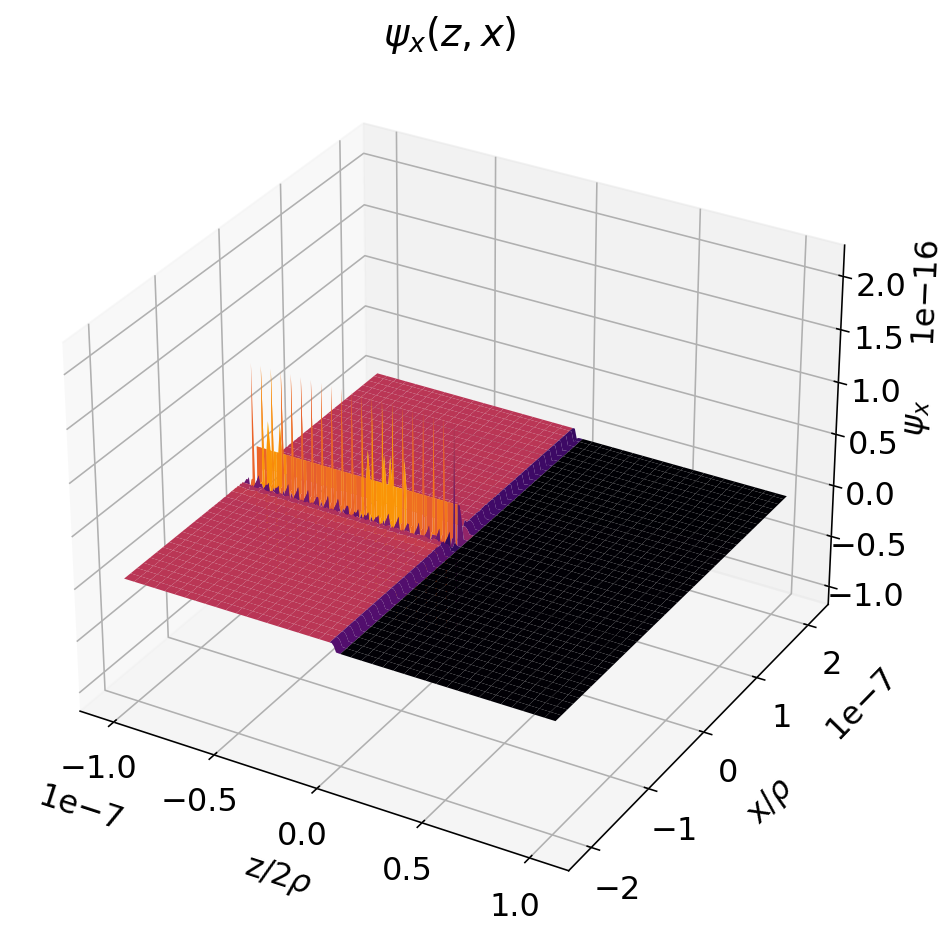

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

labelpad = 10

ax.plot_surface(zm2_no_x0 ,xm2_no_x0 , psi_x_grid_no_x0 *dx*dz, cmap='inferno')
ax.set_xlabel(r'z/2$\rho$',labelpad=labelpad)
ax.set_ylabel(r'x/$\rho$',labelpad=labelpad)
ax.set_zlabel(r'$\psi_x$')
ax.set_title(r'$\psi_x(z,x)$',pad=0)

## Defining functions for IGF calculation

In [15]:
# Want functions in terms of (z,x) only
psi_s_zx = lambda z, x: psi_s(z,x,beta)
##psi_x_zx = lambda z, x: psi_x(z,x,beta)
psi_x_zx = lambda z, x: psi_x_exact(z,x,beta)

#psi_x_z0 = lambda x: psi_x(0,x,beta)

def IGF_nquad(func, zval, xval, dz, dx):
    return integrate.nquad(func, [[zval-dz/2, zval+dz/2], [xval-dx/2, xval+dx/2]])[0]

def IGF_nquad_psi_s(z,x):
    return IGF_nquad(psi_s_zx, z, x, dz, dx)

def IGF_nquad_psi_x(z,x):
    return IGF_nquad(psi_x_zx, z, x, dz, dx)

In [16]:
# Some options for nquad
integrate.nquad(lambda z, x: z+x**2, [[0,1], [1,2]], opts={'epsabs':1e-15, 'limit':30})

(2.8333333333333335, 4.986365810377549e-14)

In [23]:
# func must have two arguments only (z,x)

def IGF_test(func, zval, xval, dz, dx):

    def func_x(x):
        return func(zval,x)
    
    if xval != 0:
        #return integrate.nquad(func, [[zval-dz/2, zval+dz/2], [xval-dx/2, xval+dx/2]], opts={'epsabs':1e-12})
        return tanh_sinh.integrate(func_x, xval-dx/2, xval+dx/2, 1e-12, max_steps=20)[0]
    else:
        term1 = tanh_sinh.integrate(func_x, -dx/2, 0, 1e-12, max_steps=20)[0]
        term2 = tanh_sinh.integrate(func_x, 0, dx/2,  1e-12, max_steps=20)[0]
        return term1 + term2
    
def IGF_test_psi_x(zval, xval):
    return IGF_test(psi_x_zx, zval, xval, dz, dx)

In [18]:
# Checking values for Some off-axis point 

print(psi_x_zx(zvec2[200],xvec2[200])*dz*dx)
print(IGF_nquad_psi_x(zvec2[200], xvec2[200]))

psi_x_temp = lambda x: psi_x_exact(zvec2[200],x,beta)
print(integrate.quad(psi_x_temp, xvec2[200]-dx/2, xvec2[200]+dx/2))
print(tanh_sinh.integrate(psi_x_temp,  xvec2[200]-dx/2, xvec2[200]+dx/2, 1e-12, max_steps=20))

-4.008629653939238e-18
-4.008629666825018e-18
(-4.0086296249146196e-09, 8.882858446925256e-17)
(-4.008632213768137e-09, mpf('2.3727203214811985e-13'))


In [19]:
# Close to origin
print(psi_x_zx(dz/2,dx/2)*dz*dx)
print(IGF_nquad_psi_x(dz/2,dx/2))

psi_x_temp = lambda x: psi_x(dz/2,x,beta)
print(integrate.quad(psi_x_temp, 0, dx)[0] * dz)
print(tanh_sinh.integrate(psi_x_temp, 0, dx, 1e-12, max_steps=20)[0]* dz)

-3.923574478084436e-18
-3.859650702723944e-18
-3.923594666293139e-18
-3.9236021343396135e-18


In [20]:
# At origin, with two 1D integrations 
#   (1) -dx/2 to 0
#   (2)  0 to dx/2

psi_x_temp = lambda x: psi_x_exact(-1e-7,x,beta)

print(integrate.quad(psi_x_temp, 0, dx/2 , epsabs=1e-10))
print(integrate.quad(psi_x_temp, -dx/2, 0, epsabs=1e-10))

print(tanh_sinh.integrate(psi_x_temp, 0, dx/2, 1e-12, max_steps=20))
print(tanh_sinh.integrate(psi_x_temp, -dx/2, 0, 1e-12, max_steps=20))

(9.792825296716099e-08, 5.494238889113708e-11)
(-9.786383461375775e-08, 5.4927343159227805e-11)
(9.792908205324938e-08, mpf('3.5370377503726761e-13'))
(-9.786466211519594e-08, mpf('3.5369347466844004e-13'))


In [434]:
# Integration from -dx/2 to dx/2 gives error

#print(integrate.quad(psi_x_temp, -dx/2, dx/2, epsabs=1e-10))
#print(tanh_sinh.integrate(psi_x_temp, -dx/2, dx/2, 1e-12, max_steps=20))

# Use map to compute the IGF for psi_s and psi_x grids

In [ ]:
## SLOW without ProcessPoolExecutor!!
# kaka = np.array(list(map( IGF_nquad_psi_s, zm2.flatten(), xm2.flatten())))
# jaja = kaka.reshape(zm2.shape)

In [374]:
# This WILL FAIL because map wants vectors not matrices. Reshape required!! 
#with cf.ProcessPoolExecutor(max_workers=20) as executor:
#    result = executor.map(IGF2_zx, zm2, xm2)
#    gg = np.array(list(result))

In [22]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=32) as executor:
    temp = np.array(list(executor.map( IGF_nquad_psi_s, zm2.flatten(), xm2.flatten())))
    psi_s_grid_IGF = temp.reshape(zm2.shape)
    
t2 = time.time()
print('IGF for psi_s takes:', t2-t1, 'sec')

IGF for psi_s takes: 55.16580080986023 sec


In [183]:
# Check if "nan" exists
np.any(np.isnan(psi_s_grid_IGF))
#psi_s_grid_IGF = np.where(np.isnan(psi_s_grid_IGF), 0, psi_s_grid_IGF)

In [24]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=20) as executor:
    temp = np.array(list(executor.map( IGF_test_psi_x, zm2.flatten(), xm2.flatten())))
    psi_x_grid_IGF = temp.reshape(zm2.shape)
    
t2 = time.time()
print('IGF for psi_x takes:', t2-t1, 'sec')

IGF for psi_x takes: 72.87562870979309 sec


Text(0.5, 0.92, '$\\psi_s(z,x)$ IGF with nquad')

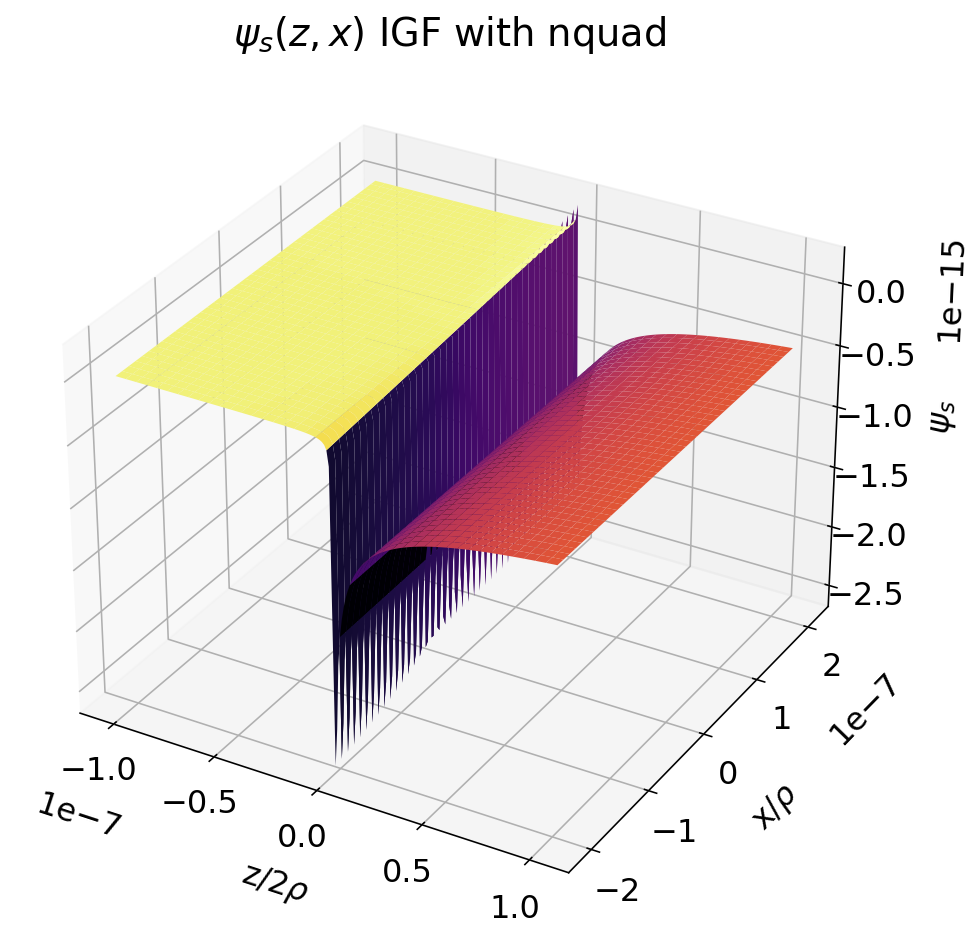

In [46]:
Z, X = np.meshgrid(zvec2,xvec2, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z,X, psi_s_grid_IGF, cmap='inferno')
ax.set_xlabel(r'z/2$\rho$', labelpad = 12)
ax.set_ylabel(r'x/$\rho$',labelpad = 12)
ax.set_zlabel(r'$\psi_s$', labelpad = 12)
ax.set_title(r'$\psi_s(z,x)$ IGF with nquad')


In [26]:
from ipywidgets import interactive
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets

In [49]:
def plot_psi_s(xix):
    vv1 = psi_s_grid[:,xix]*dx*dz
    vv2 = psi_s_grid_IGF[:,xix]
    plt.plot(zvec2, vv1,'-o', markersize=5, linewidth=1.5, label = r'$\psi_s$',color='red')
    plt.plot(zvec2, vv2,linewidth=3, label = r'$\psi_s$ IGF',color='blue')


    plt.xlabel(r'z/$2\rho$', fontsize=16)
    plt.ylabel(r'$\psi_s (1/m^2)$', fontsize=16)
    plt.title(fr'$\psi_s(z,x)$ along x={xvec2[xix]:9.3e} mm',  fontsize=20, pad=20)
    plt.legend()

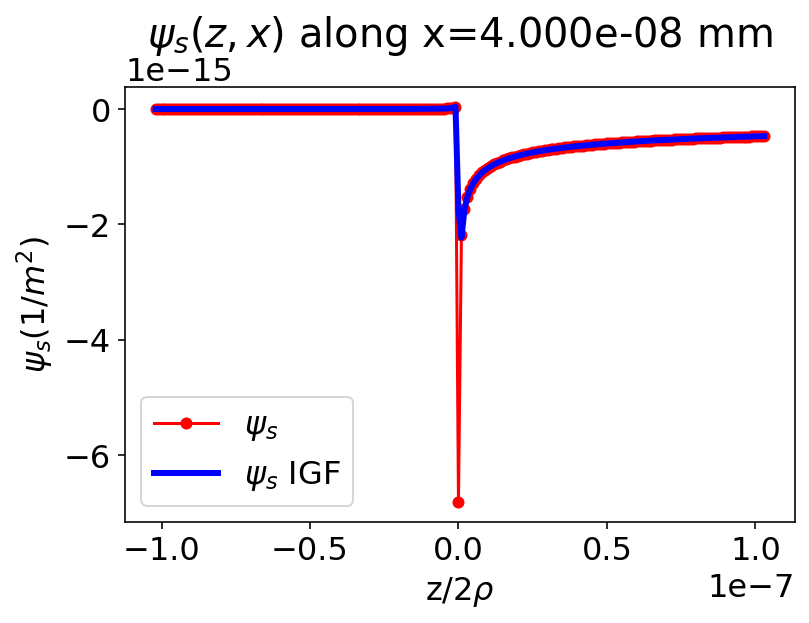

In [50]:
plot_psi_s(124)

In [51]:
interactive_plot = interactive(plot_psi_s, xix=(1, len(xvec2)))
interactive_plot

interactive(children=(IntSlider(value=105, description='xix', max=210, min=1), Output()), _dom_classes=('widge…

Text(0.5, 0.92, '$\\psi_x(z,x)$ IGF with tanh-sinh')

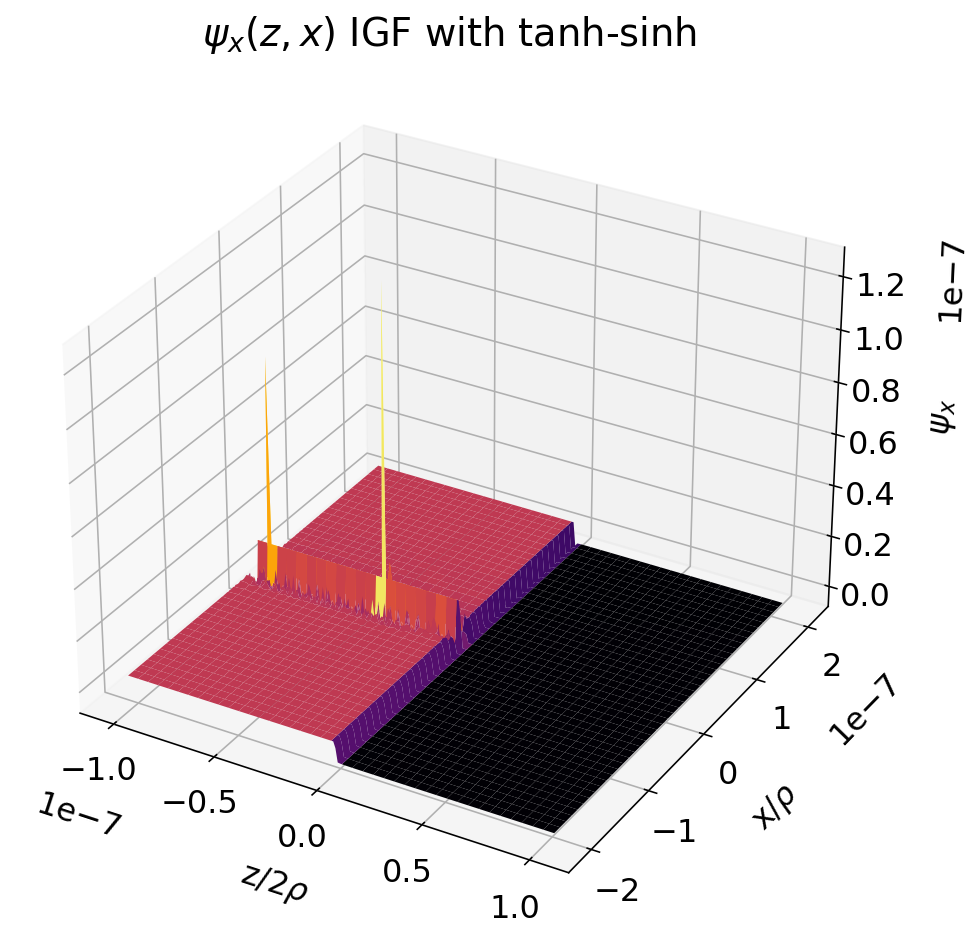

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(zm2, xm2, psi_x_grid_IGF, cmap='inferno')
ax.set_xlabel(r'z/$2\rho$', labelpad = 12)
ax.set_ylabel(r'x/$\rho$', labelpad = 12)
ax.set_zlabel(r'$\psi_x$', labelpad = 12)
ax.set_title(r'$\psi_x(z,x)$ IGF with tanh-sinh')

In [55]:
def plot_psi_x(xix):
    vv1 = psi_x_grid[:,xix]*dx*dz
    vv2 = psi_x_grid_IGF[:,xix]*dz
    plt.plot(zvec2, vv1, '-o', markersize=4, linewidth=1.5, label = r'$\psi_x$',color='red')
    plt.plot(zvec2, vv2, linewidth=3, label = r'$\psi_x$ IGF',color='blue')


    plt.xlabel(r'z/2$\rho$', fontsize=16)
    plt.ylabel(r'$\psi_x (1/m^2)$', fontsize=16)
    plt.title(fr'$\psi_x(z,x)$ along x={xvec2[xix]:9.3e} mm',  fontsize=20, pad=20)
    plt.legend()

In [56]:
interactive_plot = interactive(plot_psi_x, xix=(1, len(xvec2)))
interactive_plot

interactive(children=(IntSlider(value=105, description='xix', max=210, min=1), Output()), _dom_classes=('widge…

In [52]:
def plot_psi_x(zix):
    vv1 = psi_x_grid[zix,:]*dx*dz
    vv2 = psi_x_grid_IGF[zix,:]*dz
    plt.plot(xvec2, vv1,'-o', markersize=4 ,linewidth=1.5, label = r'$\psi_x$',color='red')
    plt.plot(xvec2, vv2,linewidth=3, label = r'$\psi_x$ IGF',color='blue')


    plt.xlabel(r'x/$\rho$', fontsize=16)
    plt.ylabel(r'$\psi_x (1/m^2)$', fontsize=16)
    plt.title(fr'$\psi_x(z,x)$ along z={zvec2[zix]:9.3e} mm',  fontsize=20, pad=20)
    plt.legend()

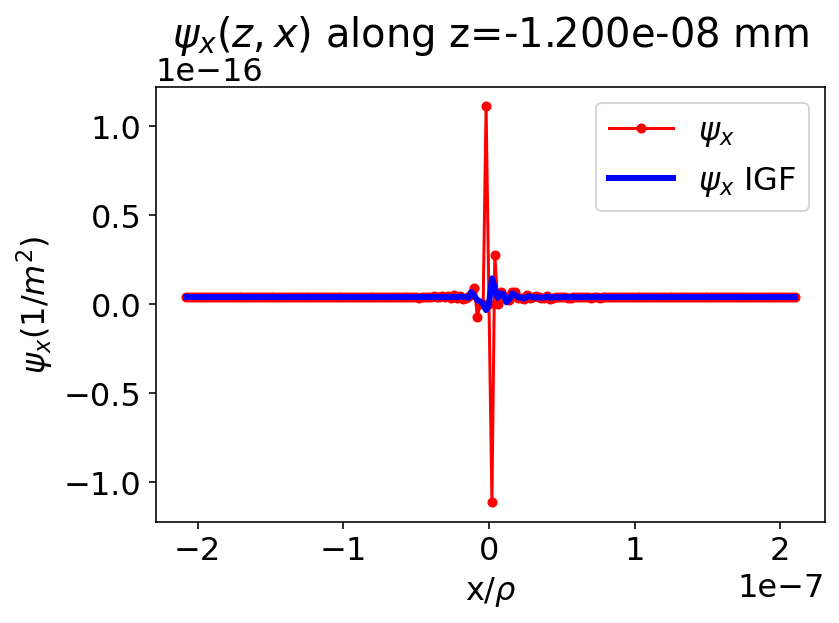

In [53]:
plot_psi_x(90)